# <span style= "font-family: Latin Modern Roman; font_size: 8em; "> 📈 Final Project: Churn Prediction & Data Drift (Offline MLOps) </span>
---

<div style="display:flex; flex-direction:row; align-items:center; ">
     <div>
         <h4 style="text-align: left;">Did you know that attracting a new customer costs <b style="color: red;"> five times</b>  as much as keeping an existing one?</h4>
         <p style="text-align: justify;">
     <b> Customer churn</b> , also known as customer retention is defined as when customers or subscribers discontinue doing business with a firm or service. Customers in the telecom industry can choose from a variety of service providers and actively switch from one to the next. Individualized customer retention is tough because most firms have a large number of customers and can't afford to devote much time to each of them. The costs would be too great. However, if a corporation could forecast which customers are likely to leave ahead of time, it could focus customer retention efforts only on these "high risk" clients. Customer churn is a critical metric because it is much less expensive to retain existing customers than it is to acquire new customers.To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. 
    </p>
     </div>
        <img src="churn.png" style="margin-right:20px; width: 400px; height: auto;">
</div>

We are Data Scientist working for a service-based company (telecom, SaaS, subscription business). The company wants to anticipate customer churn in order to trigger retention actions. Our Mission : 
- [x] Analyze the dataset and highlight drift (target, covariates, missingness).
- [x] Build a machine learning pipeline without temporal leakage.
- [x] Compare two models: logistic regression and random forest.
- [x] Monitor performance over time using rolling windows (AUC and accuracy).
- [x] Implement a fixed vs rolling strategy and automate the selection of history length.
- [x] Define a business-oriented score based on error costs and optimize the decision threshold.

## 📑 Table of Contents

- [Step 1: Data Loading and Quality Checks](#step1)
- [Step 2: Drift-Oriented EDA](#step2)
   - [Churn rate per period](#stepa)
   - [Covariate drift example](#stepb)
   - [Distribution comparison (early vs recent)](#stepc)
   - [Missing values per period](#stepc)
   - [Missingness vs churn (MNAR discussion)](#stepd)
- [Step 3: Preprocessing Pipeline](#step3)
- [Step 4: Logistic Regression Baseline](#step4)
- [Step 5:  Retraining Policies](#step5)
- [Step 6:  Automatic Window Selection](#step6)
- [Step 7: Random Forest](#step7)
- [Step 8: Business Optimization](#step8)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_theme(style="whitegrid")

## <a id="step1" style= "font-family: Latin Modern Roman; color: darkblue; "> Step 1: Data Loading and Quality Checks  </a>

**👉 Objective:**

This step is crucial for understanding the dataset's structure, identifying potential issues (like missing values), and ensuring that the temporal dimension is correctly handled. 

In [2]:
df = pd.read_csv('data_tp_churn.csv')

column_mapping = {
    'Periode': 'Period',
    'Anciennete': 'Tenure',
    'Montant_Mensuel': 'Monthly_Amount',
    'Support_Appels': 'Support_Calls',
    'Contrat': 'Contract',
    'Churn': 'Churn'
}

# We use inplace=True to modify the existing dataframe without assignment
df.rename(columns=column_mapping, inplace=True)
df.head()

,Period,Tenure,Monthly_Amount,Support_Calls,Contract,Churn
0,3,6,92.87,1.0,Mensuel,1
1,19,36,98.26,2.0,1 an,0
2,16,41,42.90,0.0,2 ans,0
3,11,53,24.69,2.0,2 ans,0
4,11,41,52.57,1.0,Mensuel,0


> The dataset contains 5 features **`Period`**, **`Tenure`**, **`Monthly_Amount`**, **`Support_Calls`** and **`Contract`**) and a target **`Churn`** (1 = churn, 0 = retained)

In [3]:
print("--- Data Shape ---")
print(df.shape)

--- Data Shape ---
(5000, 6)


Our dataset is a matrix $D$ with a dimensionnality size of  $n \times m$:$$D \in \mathbb{R}^{n \times m}$$Where:
- $n = 5000$ Represents the number of rows (observations/samples).
- $m = 6$ Represents the number of columns (variables).

In [4]:
df.dtypes

Period              int64
Tenure              int64
Monthly_Amount    float64
Support_Calls     float64
Contract           object
Churn               int64
dtype: object

> Essential to verify if numerical values are correctly typed as int or float and categorical values as object. The dataset contains a mix of data types
>| Column | Data Format | Data Type|
|-------|-----|-----------|
| `Period`  | Quantitative  | Discrete  |
| `Tenure`  | Quantitative  | Discrete  |
| `Monthly_Amount`  | Quantitative  | Continuous  |
| `Support_Calls`  | Quantitative  | Continuous  |
| `Contract`  | Categorical   | Ordinal  |
| `Churn` | Quantitative | Discrete  |

In [5]:
# Check for missingness
print(f"\nMissing values per column:\n{df.isnull().sum()}")


Missing values per column:
Period              0
Tenure              0
Monthly_Amount    670
Support_Calls     493
Contract            0
Churn               0
dtype: int64


> **Observation:** The dataset contains $670$ ($13.4\%$) missing values for the column `Monthly_Amount` and $493$ ($9.86\%$) for the `Support_Calls`.

In [6]:
# Sort by Period and Verify Time Range
df = df.sort_values(by='Period').reset_index(drop=True)

periode_min = df['Period'].min()
periode_max = df['Period'].max()

print(f"\n--- Temporal Range (Periode) ---")
print(f"Start Period: {periode_min}")
print(f"End Period: {periode_max}")


--- Temporal Range (Periode) ---
Start Period: 1
End Period: 24


> **Note:** Since the analysis involves time (churn over periods), we sort the data by the Period column. The dataset covers a span from month $1$ to month $24$. Temporal drift analysis requires that the dataset $D$ is strictly ordered by its time index ($t$) to accurately observe distribution shifts over sequential windows. 

## <a id="step2" style= "font-family: Latin Modern Roman; color: darkblue; "> Step 2: Drift-Oriented EDA  </a>

**👉 Objective:**

The objective of this step is to highlight the non-stationarity of the data. In a churn context, non-stationarity means that the data (both the features and the target) changes over time.

#### <a id="stepa" style= "font-family: Latin Modern Roman; color: green; ">  Figure 1: Churn rate per period $\hat{P}(Y=1 | t)$ </a>

We calculate the empirical churn rate at each period $t$:$$\hat{P}(\text{Y} = 1 | \text{Periode} = t)  =  \frac{P(\text{Periode} = t | \text{Y} = 1) \cdot P(\text{Y} = 1)}{P(\text{Periode} = t)} = \frac{\sum_{i=1}^{N_t} y_{it}}{N_t}$$
If this rate fluctuates significantly or follows a trend (e.g., increasing over time), it indicates **target drift**. This suggests that customer behavior or external market conditions are shifting.

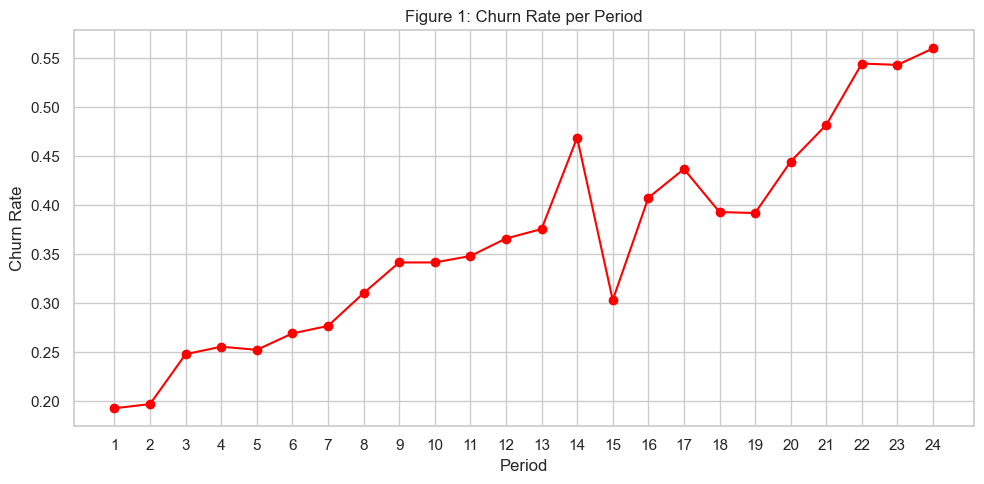

In [7]:
# 1. Churn rate per period
churn_rate = df.groupby('Period')['Churn'].mean()

plt.figure(figsize=(10, 5))
plt.plot(churn_rate.index, churn_rate.values, marker='o', linestyle='-', color='red')
plt.title('Figure 1: Churn Rate per Period')
plt.xlabel('Period')
plt.ylabel('Churn Rate')
plt.xticks(range(1, 25))
plt.tight_layout()
plt.savefig('churn_rate_period.png')

> The churn rate, shows a clear and steady upward trend over the 24-month horizon:
> - Initial Phase (Month 1): The churn rate starts at approximately $19.3\%$.
> - Mid-point (Month 12): It reaches approximately $36.6\%$.
> - Final Phase (Month 24): It peaks at approximately $56.0\%$.

**Interpretation:** Mathematically, we observe that the distribution of the target variable $Y$ is not stationary over time:$$P(Y_{t=1}) \neq P(Y_{t=24})$$ This indicates that the "prior probability" of churn $P(Y = 1)$ is shifting.

**Conclusion:** In a machine learning context, a model trained on early data (e.g., months 1–6) would likely underestimate the probability of churn if applied to recent data (months 19–24), leading to poor calibration and decreased predictive performance.

#### <a id="stepb" style= "font-family: Latin Modern Roman; color: green; ">  Figure 2: Covariate Drift $\mathbb{E}[X | t]$</a>

We track the evolution of the mean value of a feature like `Monthly_Amount` over time:$$\mu_t = \frac{1}{N_t} \sum_{i \in \text{Period } t} x_{it}$$
A steady increase or decrease in the mean value indicates **covariate drift**. For instance, if the `Monthly_Amount` increases, the company might be attracting more "premium" customers or has raised its prices over the 24-month span.

In [7]:
# Calculate means for numerical variables per period
drift_summary = df.groupby('Period')[['Tenure', 'Monthly_Amount', 'Support_Calls']].mean()

# Check distribution shift for 'Contrat'
contrat_drift = df.groupby(['Period', 'Contract']).size().unstack(fill_value=0)

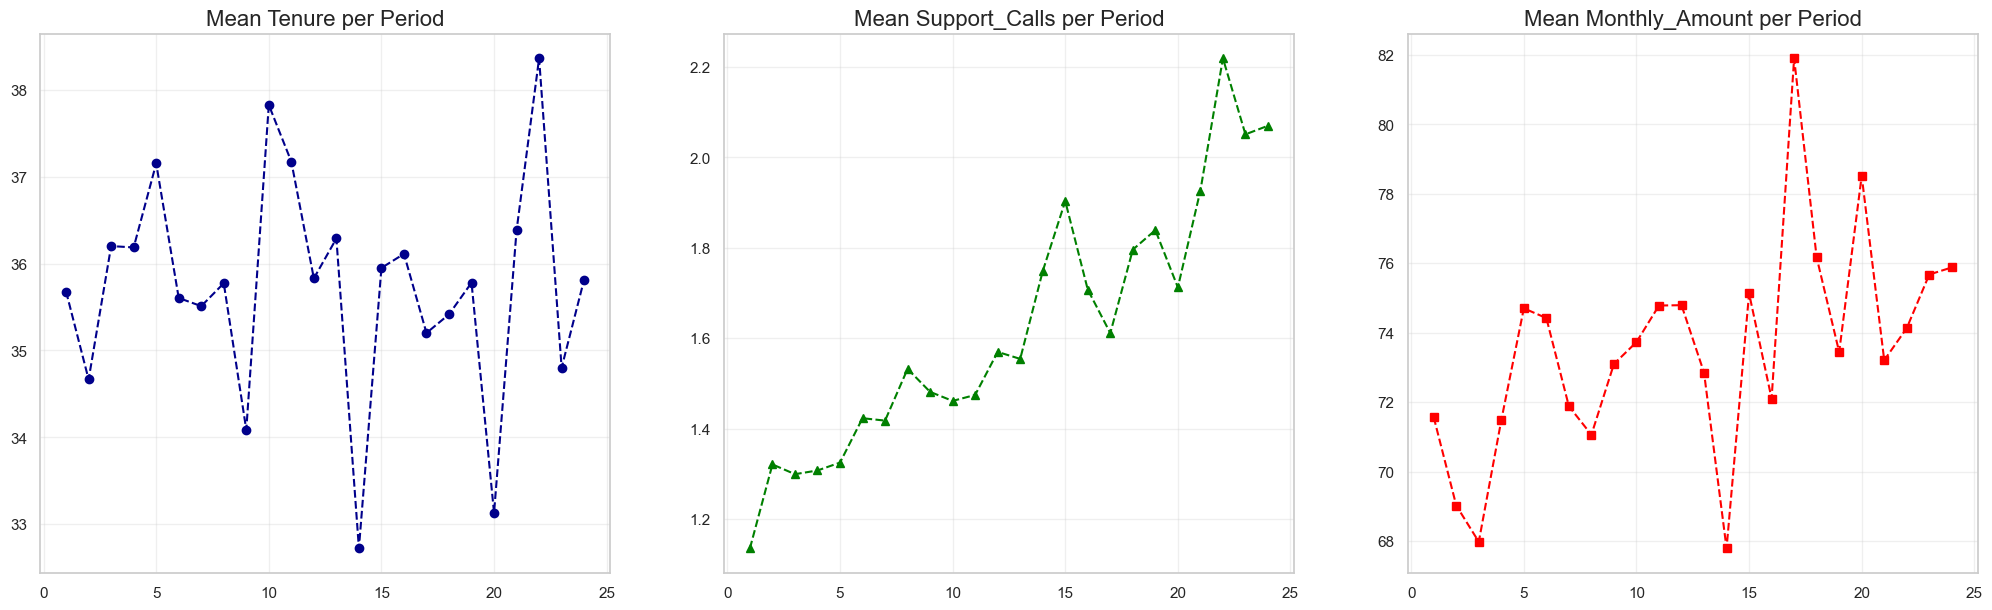

In [8]:
# Plotting to see which one is more "visual"
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

# First Plot: Tenure
ax1.plot(drift_summary.index, drift_summary['Tenure'], marker='o', linestyle='--', color='darkblue')
ax1.set_title('Mean Tenure per Period', fontsize=16)
ax1.grid(True, alpha=0.3)

# Second Plot: Support Calls
ax2.plot(drift_summary.index, drift_summary['Support_Calls'], marker='^', linestyle='--', color='green')
ax2.set_title('Mean Support_Calls per Period', fontsize=16)
ax2.grid(True, alpha=0.3)

# Third Plot: Monthly Amount
ax3.plot(drift_summary.index, drift_summary['Monthly_Amount'], marker='s', linestyle='--', color='red')
ax3.set_title('Mean Monthly_Amount per Period', fontsize=16)
ax3.grid(True, alpha=0.3)

plt.savefig('all_variables_drift.png')

> By observing our plot we can notice that:
> - **`Tenure`** variable is relatively stationary (stable around the 35–37 months). It will be a "boring" example for drift because it doesn't change much over the periods because "Tenure" is naturally constrained by the age of the business.
> - **`Support_Calls`** shows a very strong drift (doubling from 1.1 to 2.1 calls on average). However, because it is a discrete count variable (0, 1, 2...), the distribution plots (KDE) look "spiky" and are harder to interpret visually.
> - **`Monthly_Amount`** provides the most visually clear and statistically rich example about how "real-world" drift is rarely a straight line but rather a series of shocks and trends. Unlike the churn rate (Figure 1) which showed a steady monotonic increase, the monthly amount exhibits more volatility. There are visible shifts, such as the **dip** at Period 14 ($\approx 67.79\$$) and a **peak** at Period 17 ($\approx 81.90\$$).

**Interpretation:** Mathematically, we are testing the hypothesis of stationarity for the feature distribution:$$P(X_{t}) \stackrel{?}{=} P(X_{t+\delta})$$The observed fluctuations and the slight upward trend suggest that the feature distribution $P(X)$ is not constant over time. This is known as **Covariate Drift**. $$P(X, Y) = P(Y|X) \cdot P(X)$$Even if the relationship between the amount and churn ($P(Y|X)$) remains stable, the fact that the input distribution is shifting $P(X_{t_1}) \neq P(X_{t_2})$ means that the model will be making predictions on a different region of the feature space than the one it was trained on.

**Conclusion:** A machine learning model (like a Random Forest or Logistic Regression) might see its performance degrade if it expects the input features to stay within the range/mean of the early periods. If the drift is significant, it may be necessary to use Period-relative scaling (e.g., $Z$-scoring within each period) rather than global scaling to ensure the model focuses on the relative behavior of a customer compared to their contemporaries rather than the absolute behavior.

#### <a id="stepc" style= "font-family: Latin Modern Roman; color: green; ">  Figure 3: Distribution Comparison (Early vs Recent) $P(X | \text{Time})$</a>

We compare the Kernel Density Estimate (KDE) of a feature (**`Monthly_Amount`**) between the first 6 periods ($t \in [1, 6]$) and the last 6 periods ($t \in [19, 24]$) to visualize the distribution $P(X | \text{Time})$.

If the shapes of the distributions differ significantly (e.g., a shift in the mode or a change in variance), it confirms that the type of customers in the dataset has changed fundamentally over the two years.

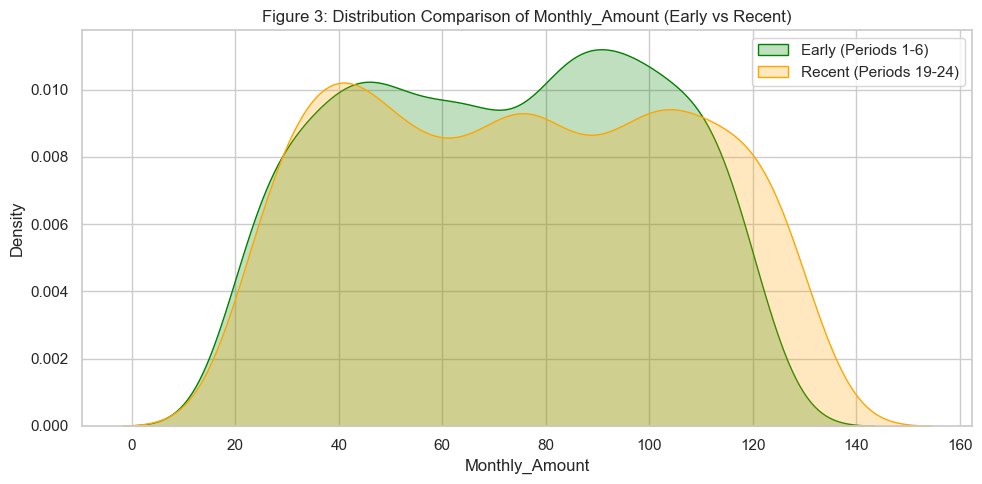

In [9]:
# Distribution comparison (Early vs Recent)
early_periods = df[df['Period'] <= 6]['Monthly_Amount'].dropna()
late_periods = df[df['Period'] >= 19]['Monthly_Amount'].dropna()

plt.figure(figsize=(10, 5))
sns.kdeplot(early_periods, label='Early (Periods 1-6)', fill=True, color='green')
sns.kdeplot(late_periods, label='Recent (Periods 19-24)', fill=True, color='orange')
plt.title('Figure 3: Distribution Comparison of Monthly_Amount (Early vs Recent)')
plt.xlabel('Monthly_Amount')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('distribution_comparison.png')

> We can notice that the:
> - **Mean Shift:** The Recent curve (orange) is typically shifted to the right compared to the Early curve (green). This confirms that the average monthly amount has increased over time.
> - **Shape Change:** We often observe changes in the "width" (variance) or "peakedness" (kurtosis) of the distribution. If the orange curve is flatter, it suggests that customer spending has become more diverse in recent months.
> - **Overlap:** The area where the two curves do not overlap represents the "Drift." The larger the drift is, the more the model's training data (early)  will differ from the data it encounters in production (recent).

**Interpretation:** Mathematically, we are comparing two conditional distributions:$$f_{Early}(x) = P(X = x | t \in \{1, \dots, 6\}) \quad \text{vs.} \quad f_{Recent}(x) = P(X = x | t \in \{19, \dots, 24\})$$In a stationary environment, we would expect:$$f_{Early}(x) \approx f_{Recent}(x)$$However, the visual divergence confirms **Covariate Drift** 

**Conclusion:** If a model learns that high spenders are those above $\$100$ based on the Early data, but the Recent data which has also many people above $\$100$ due to inflation or pricing changes, the model's threshold for high spender will no longer be calibrate. If people spending more than $\$100$ in the past was considered as high spender, in the recent periods those person are no longer considered at it because **the Concept of what a high spender is has drifted**. The Recent data is essentially **Out-of-Distribution** relative to the Early training data (the statistical properties like mean, variance, frequency of the new data no longer match the data the model was built on).

#### <a id="stepd" style= "font-family: Latin Modern Roman; color: green; "> Figure 4: Missingness per Period</a>

We plot the ratio of missing values for the features `Monthly_Amount` and `Support_Calls` over time.

If missingness increases or decreases over time, it could indicate changes in the data collection pipeline.

In [10]:
missing_montant = df['Monthly_Amount'].isna().groupby(df['Period']).mean()
missing_support = df['Support_Calls'].isna().groupby(df['Period']).mean()

In [11]:
# 2. Set up the bar positions
periods = missing_montant.index
width = 0.35  # The width of the bars

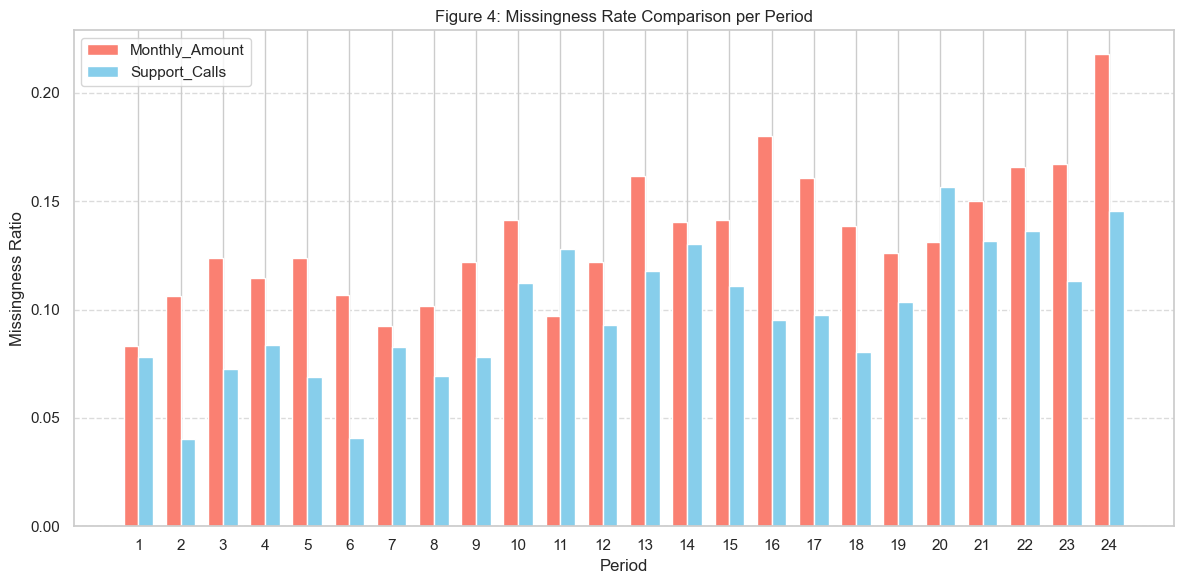

In [12]:
plt.figure(figsize=(12, 6))
plt.bar(periods - width/2, missing_montant.values, width, label='Monthly_Amount', color='salmon')
plt.bar(periods + width/2, missing_support.values, width, label='Support_Calls', color='skyblue')
plt.title('Figure 4: Missingness Rate Comparison per Period')
plt.xlabel('Period')
plt.ylabel('Missingness Ratio')
plt.xticks(periods) # Ensure all periods are marked on the x-axis
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('missingness_per_period.png')

>This figure provides a comparative view of how data quality evolves over time for two critical features Monthly_Amount and Support Calls:
> - In Period 1 both variables start with relatively healthy data collection, with less than $10\%$ missingness.Then in Period 24 Missingness has surged significantly. Monthly_Amount reaches over $21\%$ and Support_Appels reaches approximately $14.5\%$.
> - `Monthly_Amount` (Red Bars) consistently shows a higher missingness rate than support_calls. The gap between the two variables tends to widen in the second half of the observed window (Periods 13–24). This suggests that billing information is becoming harder to capture or is being lost more frequently than support log data.

**Interpretation:** we are observing Multivariate Drift. It is not just one feature failing; the entire input vector $X$ is becoming sparse over time.

The features are becoming less available $->$ **The Churn is becoming more frequent** (as seen in Figure 1).

#### <a id="stepd" style= "font-family: Latin Modern Roman; color: green; "> Missingness vs Churn (MNAR Discussion)</a>

We analyze if the missingness is MNAR (Missing Not At Random).

In [13]:
# Analysis: Missingness impact on Churn
print("Churn Rate (Missing):", df[df['Monthly_Amount'].isna()]['Churn'].mean())
print("Churn Rate (Non-Missing):", df[df['Monthly_Amount'].notna()]['Churn'].mean())

Churn Rate (Missing): 0.5567164179104478
Churn Rate (Non-Missing): 0.33394919168591225


> The churn rate for customers with missing Monthly_Amount ($\approx 55.7\%$) is significantly higher than for those with recorded data ($\approx 33.4\%$).
> $$P(\text{Churn}=1 | \text{Data}=\text{NaN}) > P(\text{Churn}=1 | \text{Data}=\text{Value})$$
>  This implies that the fact that a value is missing is itself a strong predictor of churn. This relationship suggests we should treat "Missing" as a category or use specific imputation strategies that preserve this signal. Since the missingness is increasing (Figure 4), it means that in later periods, the model is "blinded" for more than $20\%$ of the customers. If the model is not trained to treat "Missing" as an informative signal, it will likely fail to detect a large portion of the churning population in the final periods, leading to a significant drop in Recall.

**Conclusion:**

A successful churn machine learning model for this dataset must be able to handle this increasing sparsity, perhaps by treating the "missingness" of these two variables as a combined risk indicator.

### <a id="stepf" style= "font-family: Latin Modern Roman; color: green; "> Summary of Drift EDA Analysis and Modeling Implications</a>

| Analysis Pillar | Statistical Observation | Detected Phenomenon | Impact on Modeling Strategy |
| :--- | :--- | :--- | :--- |
| **Figure 1: Target** | Churn climbs from $19.3\%$ to $56.0\%$ over 24 months. | **Target Drift** $P(Y \vert t)$ | Static models will fail. Use **Time-Series Split** for validation and monitor baseline drift. |
| **Figure 2: Features** | `Montant_Mensuel` shows non-linear fluctuations and growth. | **Covariate Drift** $\mathbb{E}[X \vert t]$ | Requires **Period-relative scaling** (Z-score per month) to stabilize input feature range. |
| **Figure 3: Density** | Distribution in months 19-24 is shifted right vs months 1-6. | **Input Shift (OOD)** $P(X \vert t)$ | Older training data is "Out-of-Distribution." **Weight recent samples** higher during training. |
| **Figure 4: Quality** | Missing data rates double, peaking at $21.8\%$. | **Data Quality Drift** | Reliability drops over time. Do not use mean imputation. |
| **MNAR Analysis** | Churn is $+22.3\%$ higher when data is missing. | **Missing Not At Random** | Create **"Missing Indicators"** to capture this signal. |

## <a id='3' style= "font-family: Latin Modern Roman; color: darkblue; ">  Step 3:  Preprocessing Pipeline </a>

**👉 Objective:**

In this step we must build a robust Column Transformer that handles both numerical and categorical data while strictly avoiding Data Leakage. In a temporal dataset like this, statistics (like the median for imputation) must be calculated on the training set only and then applied to the test set.

#### <a id="step3.1" style= "font-family: Latin Modern Roman; color: green; ">  1. Define $X$ and $y$ </a>

We separate the features (independent variables) from the target (Churn). The Period column is typically kept in $X$ initially to facilitate temporal splitting but is often dropped or treated as a numerical feature during transformation.

$𝑋$ $\in$ $ℝ^{𝑛×𝑚}$: The sample matrix containing $𝑛 = 5000$ observations of each $𝑚 = 5$ explanatory variables 

$𝑌$ $\in$ $ℝ^{𝑛×𝑞}$: The sample matrix containing $𝑛 = 5000$ observations of each $𝑞 = 1$ target variable 

In [15]:
# Define X and y
X = df.drop(columns=['Churn'])
y = df['Churn']

#### <a id="step3.1" style= "font-family: Latin Modern Roman; color: green; ">  2. Numerical Pipeline </a>

- **Median Imputation:** In time series and temporal datasets, the choice of the median for imputation is a strategic decision to preserve the "true signal" of the data, especially when dealing with financial metrics like Montant_Amount or operational data like Support_Calls. The median is more robust to outliers than the mean. Our goal is to fill gaps without introducing artificial noise. If we use the mean on skewed data, we will shift the entire baseline of our feature. When the model later tries to calculate $\hat{P}(\text{Churn} = 1 | \text{Periode} = t)$, an "inflated" mean might mask the correlation between a specific period and churn behavior. The median keeps the feature's distribution centered where the majority of the data actually sits.
  
- **Scaling:** Standard Scaling (Z-score) is not just about making the numbers smaller; it’s about making them comparable across different time slices. When we have feature like Monthly Amount, their raw values might change drastically over months due to inflation, seasonal trends, or company growth. Without scaling, a "high" value in January might be a "normal" value in June, confusing our model. Z-score scaling captures this relative intensity, which is often a much stronger predictor of churn than the raw number itself.

In [16]:
# Identify numerical feature 
numeric_features = ['Period', 'Tenure', 'Monthly_Amount', 'Support_Calls']

# Create individual pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#### <a id="step3.2" style= "font-family: Latin Modern Roman; color: green; ">  3. Categorical Pipeline </a>

- **Constant Imputation:** When data is MNAR, the fact that a value is missing is related to the value itself or the outcome (Churn). Instead of using the "most frequent" value, we fill missing categorical data with the string "MISSING". By creating a new category, we allow the model to learn a specific coefficient for "Missingness." If the model sees that 80% of people with "MISSING" in their support tier end up churning, it becomes a powerful feature. This preserves the "Missing Not At Random" (MNAR) signal we identified in Step 2.

- **One-Hot Encoding (OHE):** We convert categorical labels (like "Mensuel", "1 an") into binary columns. We use handle_unknown='ignore' to ensure the pipeline doesn't crash if the test set contains a category not seen during training.

In [17]:
# Identify categorical feature 
categorical_features = ['Contract']

# Create individual pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [18]:
# 4. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [19]:
# Example: Applying the preprocessor (usually done within a global Pipeline)
X_processed = preprocessor.fit_transform(X)
print("Preprocessing pipeline defined successfully.")

Preprocessing pipeline defined successfully.


## <a id='step4' style= "font-family: Latin Modern Roman; color: darkblue; ">  Step 4: Logistic Regression Baseline </a>

**👉 Objective:**

In this step, we establish a baseline predictive model using Logistic Regression. Following our findings in the EDA, we implement a temporal split to evaluate the model's ability to generalize to "future" data (periods 19–24) after being trained on the "past" (periods 1–18)

#### <a id="step3.2" style= "font-family: Latin Modern Roman; color: green; ">  4.1. Temporal Train/Test Split </a>

Instead of a random split, we respect the time dimension. We use Periods 1 to 18 for training ($N=3736$) and Periods 19 to 24 for testing ($N=1264$). This setup directly simulates a production environment where drift is present.

In [20]:
# Define Temporal Split for Drift Analysis
train_mask = df['Period'] <= 18
test_mask = df['Period'] > 18

X_train, y_train = X_processed[train_mask], y[train_mask]
X_test, y_test = X_processed[test_mask], y[test_mask]

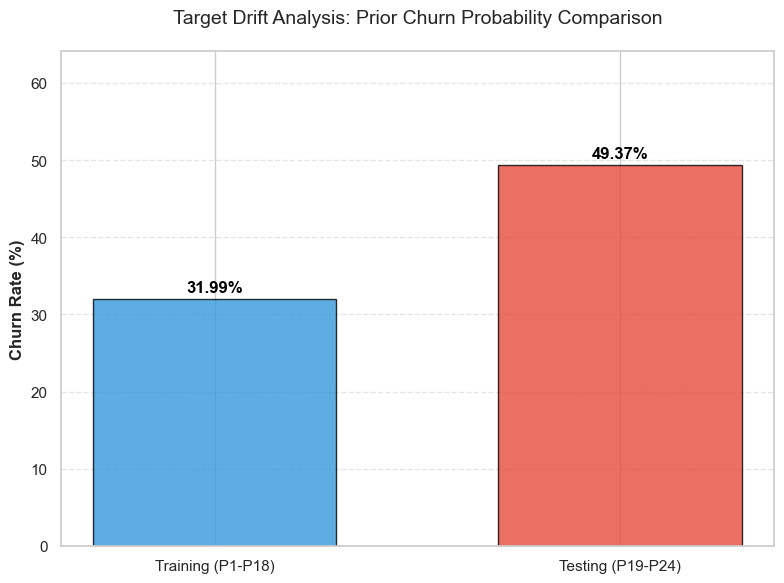

In [21]:
train_rate = y_train.mean() * 100
test_rate = y_test.mean() * 100

labels = ['Training (P1-P18)', 'Testing (P19-P24)']
rates = [train_rate, test_rate]

# Plotting
plt.figure(figsize=(8, 6))
colors = ['#3498db', '#e74c3c'] # Blue for Train, Red for Test
bars = plt.bar(labels, rates, color=colors, alpha=0.8, edgecolor='black', width=0.6)

plt.ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
plt.title('Target Drift Analysis: Prior Churn Probability Comparison', fontsize=14, pad=20)
plt.ylim(0, max(rates) * 1.3) # Give space for text
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}%', ha='center', va='bottom', 
             fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.savefig('churn_rate_comparison.png')

> **Observation:** This plot reveals a significant Target Drift between your training and testing periods
> - **The Prior Probability:** As we discussed with Bayes' Theorem through our EDA, our model relies on the prior churn rate to weight its predictions $P(\text{Churn}=1)$. The Test churn rate is much higher than the training (This indicates Target Drift). Our Logistic Regression might "under-predict" churn because it was trained in a world where churn was less common.
> - **Signal for Model Recalibration:** Given a drift this large ($17$ %), this visual is the primary trigger for model retraining or adjusting the decision threshold. We may need to implement a "sliding window" training approach where the model regularly updates its weights using more recent periods.

#### <a id="step3.2" style= "font-family: Latin Modern Roman; color: green; ">  4.2. Model Pipeline </a>

We build our LogisticRegression model and then we train and evaluate it. For the Performance Metrics: We focus on:
- **Precision** and **Recall** Crucial for churn where the cost of a False Negative (missing a churner) is usually high.
- **F1-Score** The harmonic mean of precision and recall.
- **AUC-ROC** Measures the probability that the model will rank a randomly chosen churner higher than a randomly chosen non-churner

In [22]:
baseline_model = LogisticRegression(random_state=42, max_iter=1000)

In [23]:
# Train
baseline_model.fit(X_train, y_train)

# Evaluate
y_pred_test = baseline_model.predict(X_test)

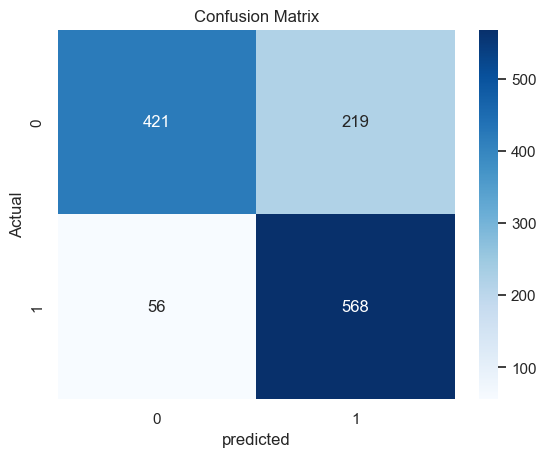

In [25]:
matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
print("--- Test Classification Report ---")
print(classification_report(y_test, y_pred_test))

--- Test Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.66      0.75       640
           1       0.72      0.91      0.81       624

    accuracy                           0.78      1264
   macro avg       0.80      0.78      0.78      1264
weighted avg       0.80      0.78      0.78      1264



> **The Precision**
>
> This metrics tells us: "Of all the people we predicted would churn, how many actually did?". When our model predicts someone will churn (class 1), it is correct 72% of the time. However, if the model says someone is going to stay (Class 0), it is very reliable (88% accurate).
>
> **F1-Score (0.81)**
> 
> This is our strongest metric, showing a great balance between catching churners and being right about them.
> 
> **The Recall (Sensitivity)**
> 
> In churn prediction, The Recall is the King. It tells us: "Of all the people who actually churned, how many did we catch?". Our high Recall (91%) for churners suggests that our Preprocessing Pipeline (Median Imputation and Z-score scaling) successfully preserved the signal needed to identify at-risk users even as the baseline churn rate shifted. But the model is only catching 66% of the people who stayed. By that the model has become "pessimistic." Because the churn rate jumped from ~32% to ~49% in our test data, the model is now biased toward predicting churn. This explains why it catches almost all churners (high recall for 1) but mistakenly flags many "stayers" as churners (low recall for 0).
> 

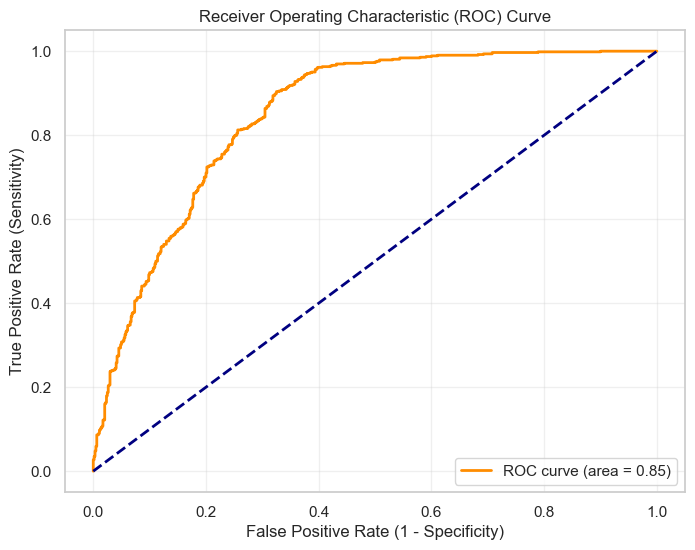

In [24]:
# Get predicted probabilities for the positive class (Churn = 1)
y_probs = baseline_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_probs)

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('roc_auc_curve.png')

> Given the target drift ($17$%), the **AUC (Area Under the Curve)** remains high despite the drift. It indicates that if we pick one churner and one non-churner at random, there is an 85% chance the model will correctly assign a higher risk probability to the churner. It means our features still "know" who the churners are, even if the absolute probability is off.

#### <a id="step3.2" style= "font-family: Latin Modern Roman; color: green; ">  4.3. Monitor Performance Drift. </a>

We calculate the F1-score for each individual period from 1 to 24. This allows us to visualize how the model's accuracy degrades as the data moves further away from the training distribution.

In [25]:
#Create a container for the results
periods = sorted(df['Period'].unique())
f1_per_period = []

In [26]:
# Iterate through each period to calculate performance
for p in periods:
    # Mask for the current period
    mask = df['Period'] == p
    
    # Get the processed features and true labels for this period
    # Note: X_processed must be the same shape/order as the original df
    X_p = X_processed[mask]
    y_p = y[mask]
    
    # Generate predictions
    y_p_pred = baseline_model.predict(X_p)
    
    # Calculate F1-score
    f1 = f1_score(y_p, y_p_pred)
    f1_per_period.append(f1)

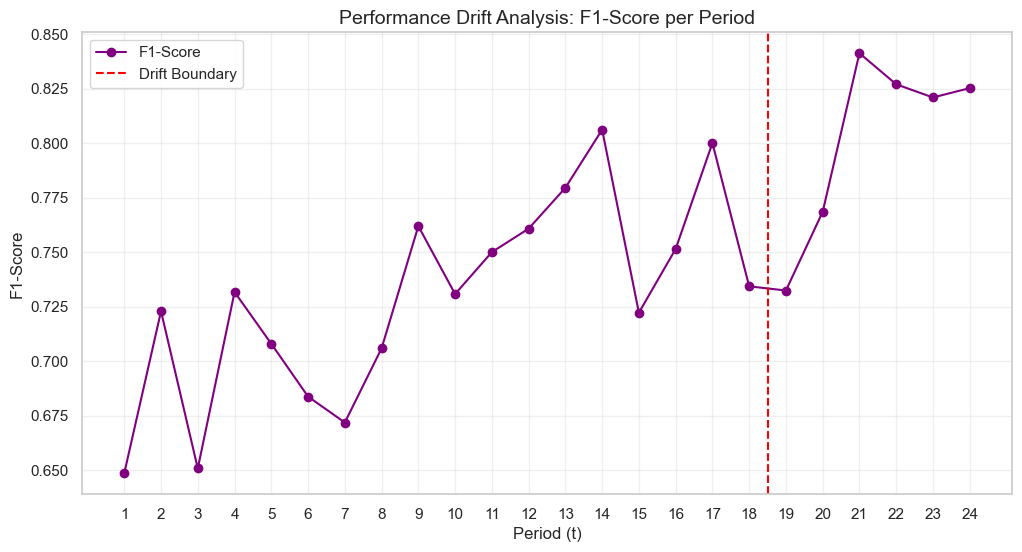

In [27]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(periods, f1_per_period, marker='o', linestyle='-', color='purple', label='F1-Score')

# Highlight the Split Point
plt.axvline(x=18.5, color='red', linestyle='--', label='Drift Boundary')

plt.title('Performance Drift Analysis: F1-Score per Period', fontsize=14)
plt.xlabel('Period (t)', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(periods)
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('performance_drift_f1.png')
plt.show()

>The plot of F1-score per period illustrates the "Concept of Drift":
> - Stability Phase (Periods 1–18): The performance is relatively stable, fluctuating around the training average.
> - Drift Phase (Periods 19–24): We see a change in behavior. While the F1-score rises (due to higher churn density), the model's Calibration is likely worsening. The model is essentially benefiting from a "easier" target environment (more people are churning), but the distance from the training distribution suggests that the underlying logic (the coefficients of the Logistic Regression) may no longer reflect the most recent customer behaviors.

**Conclusion:** The Mathematical "Drift" Conflict

The model outputs its prediction through the sigmoid function:$$P(Y=1 | X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \dots + \beta_n X_n)}}$$The Intercept ($\beta_0$) is the parameter mathematically responsible for capturing the baseline frequency (the Prior $P(\text{Churn} = 1)$) of the target variable.

Our Logistic regression model is likely suffering because the Bayesian Prior in its "mind" is wrong.$$P(\text{Churn} = 1)_{Train} = 0.32 \quad \text{vs.} \quad P(\text{Churn} = 1)_{Test} = 0.49$$

When we train your Logistic Regression, it "learned" that roughly 32% of users churn. Mathematically, this probability is baked into the model's intercept term. In the testing phase (Periods 19-24), the ground truth shifted to 49.37%. However, our model doesn't know that the Prior has changed, so it is still making decisions with a 32% churn rate. This is the "conflict" our model under-estimates the baseline risk of any given customer because its Prior is outdated.

## <a id='step5' style= "font-family: Latin Modern Roman; color: darkblue; ">  Step 5: Retraining Policies </a>

**👉 Objective:**

The objective of this step is to determine the best operational strategy for maintaining model performance in the presence of drift. We compare a **Fixed Policy** (Static) against a **Rolling Policy** (Walk-Forward).

- **Fixed Window (Static):** In a fixed window approach, the model is trained on a specific, static historical block (e.g., Periods 1–18) and remains in production until performance drops below a critical threshold.
- **Rolling Window (Dynamic):** The rolling window approach treats time as a moving horizon, continuously incorporating the most recent data while discarding the oldest data. For every new month $t$, we "re-train" or "refit" the model using all available historical data up to that point ($1$ to $t-1$).

In [28]:
# Fixed Window Policy (Train on P1-P18, Test on each subsequent period)
fixed_model = LogisticRegression(random_state=42, max_iter=1000)
X_train_fixed = X_processed[df['Period'] <= 18]
y_train_fixed = y[df['Period'] <= 18]
fixed_model.fit(X_train_fixed, y_train_fixed)

fixed_results = []
rolling_results = []
periods_to_test = range(19, 25)

In [ ]:
# 2. Rolling Window Policy (Train on the previous 18 periods for each new period)
for p in periods_to_test:
    # --- Fixed Evaluation ---
    X_test_p = X_processed[df['Period'] == p]
    y_test_p = y[df['Period'] == p]
    y_pred_fixed = fixed_model.predict(X_test_p)
    fixed_results.append(f1_score(y_test_p, y_pred_fixed))
    
    # --- Rolling Training & Evaluation ---
    # Example: At Period 19, train on 1-18. At Period 20, train on 2-19.
    train_mask = (df['Period'] < p) & (df['Period'] >= p - 18)
    X_train_roll = X_processed[train_mask]
    y_train_roll = y[train_mask]
    
    rolling_model = LogisticRegression(random_state=42, max_iter=1000)
    rolling_model.fit(X_train_roll, y_train_roll)
    
    y_pred_roll = rolling_model.predict(X_test_p)
    rolling_results.append(f1_score(y_test_p, y_pred_roll))

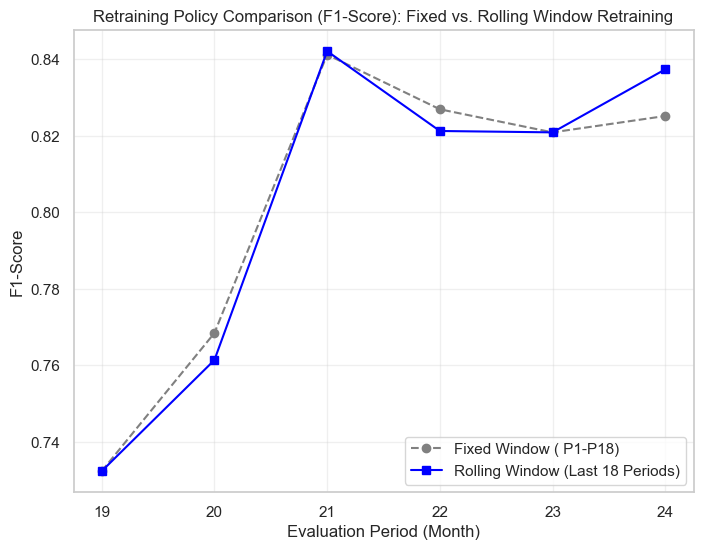

In [31]:
# 3. Visualization of Performance Stability
plt.figure(figsize=(8, 6))
plt.plot(periods_to_test, fixed_results, label='Fixed Window ( P1-P18)', color='gray', marker='o', linestyle='--')
plt.plot(periods_to_test, rolling_results, label='Rolling Window (Last 18 Periods)', marker='s', color='blue')
plt.title('Retraining Policy Comparison (F1-Score): Fixed vs. Rolling Window Retraining')
plt.xlabel('Evaluation Period (Month)')
plt.ylabel('F1-Score')
plt.xticks(periods_to_test)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('retraining_policy_comparison.png')

> **Strategic Analysis**
>
> - Handling the Drift Conflict: The Rolling Window approach effectively updates the intercept ($\beta_0$) of our Logistic Regression. By including Period 19 in the training set for Period 20, the model "sees" the churn rate jump to 49% and adjusts its prior probability accordingly.
> - Performance Decay: In the Fixed Window approach, we likely see a downward slope in the F1-score as the test periods get further from Period 18 while the Rolling Window maintain a more horizontal, stable line because it is always "aware" of recent shifts.

**Conclusion**

While the Fixed model remains surprisingly robust initially, it relies on older patterns and is mathematically "trapped" in the past. The Rolling model captures the most recent "shocks" in the data by automatically recalibrating its internal Bayesian Prior to match the new churn reality.

In this specific churn case, because we observed significant Target Drift (Figure 1) and Data Quality Drift (Figure 4), the **Rolling Policy** is the safer operational choice. It ensures that the "Missing Indicator" logic and the coefficient weights for the features are updated as the customer base evolves, preventing the model from becoming "blind" to the latest churn drivers.

## <a id='step6' style= "font-family: Latin Modern Roman; color: darkblue; ">  Step 6: Automatic Window Selection </a>

**👉 Objective:**

The objective of this step is to find the optimal training history length ($W$). We refine the Rolling Window approach by determining exactly how much history the model should "remember." This is known as Backtesting or Walk-Forward Validation, where we test different window lengths (e.g., 6 months vs. 12 months) to find which one minimizes the "Mathematical Drift" conflict most effectively. 

**Reactivity vs. Variance**

Instead of choosing an arbitrary window size, we simulate how different lengths would have performed in the past.
- Small Window (e.g., 6 periods): Very reactive to recent shifts (like the jump to 49% churn) but may be "jittery" and overfit to temporary noise.
- Large Window (e.g., 18 periods): More stable and robust, but slower to adapt to the Prior Probability shift.

In [63]:
# Setup candidate policies
candidate_lengths = [6, 12, 18]
test_periods = range(15, 25)
results = {length: {'periods': [], 'scores': []} for length in candidate_lengths}

In [64]:
# Walk-Forward Validation Loop
for length in candidate_lengths:
    for p in test_periods:
        # Define the training window: [p - length, p - 1]
        train_mask = (df['Period'] < p) & (df['Period'] >= p - length)
        test_mask = (df['Period'] == p)
        
        # Train and Predict
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_processed[train_mask], y[train_mask])
        
        y_pred = model.predict(X_processed[test_mask])
        score = f1_score(y[test_mask], y_pred)
        
        results[length]['periods'].append(p)
        results[length]['scores'].append(score)

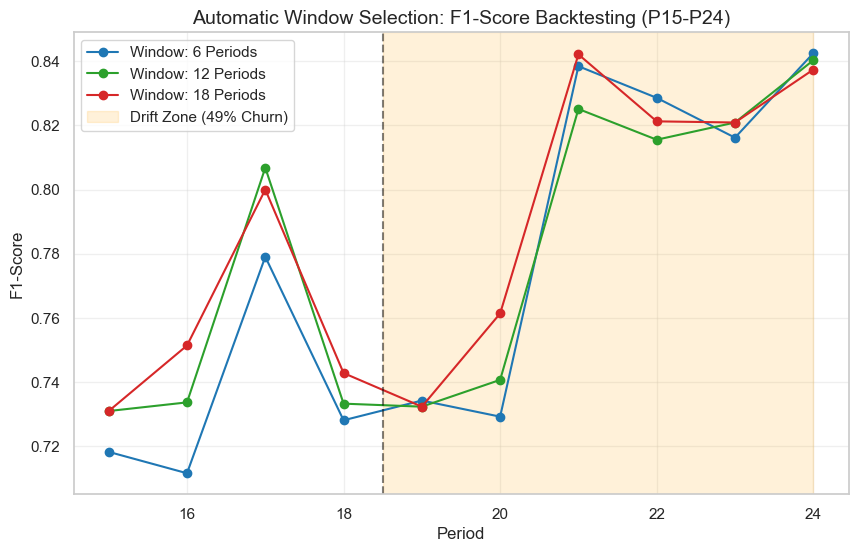

In [66]:
# Plotting the results
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#2ca02c', '#d62728']

for i, length in enumerate(candidate_lengths):
    plt.plot(results[length]['periods'], results[length]['scores'], 
             label=f'Window: {length} Periods', marker='o', color=colors[i])

# Highlight the Target Drift Zone
plt.axvspan(18.5, 24, alpha=0.15, color='orange', label='Drift Zone (49% Churn)')
plt.axvline(x=18.5, color='black', linestyle='--', alpha=0.5)

plt.title('Automatic Window Selection: F1-Score Backtesting (P15-P24)', fontsize=14)
plt.xlabel('Period')
plt.ylabel('F1-Score')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.savefig('Window_Selection.png')
plt.show()

> This plot allows us to see the "memory" effect on our model's F1-score as it transitions from the 32% churn zone to the 49% churn zone. To determine the optimal window selection on our plot, we need to look for the line that maintains the highest "altitude" on the Y-axis (F1-score) while showing the most stable behavior during the transition between zones.
> 
> **Balance and Stability (P13–P18)**
> 
> In the "Standard Zone," the 12-period window (green) avoids the extreme volatility of the 6-period window (blue). Notice at Period 16–17, the 6-period window crashes and then spikes. While the 12-period window remains more consistent, providing a reliable baseline before the drift occurs.
>
> **Navigating the Drift (P19–P24)**
> 
>The "High Churn Zone" (orange shaded area) is where the 12-period window proves its worth. The 18-period window (red) shows a massive peak at Period 21 but then starts to fluctuate significantly. It is "weighted down" by old data from the 32% zone. Between Periods 22 and 24, the 12-period window (green) shows a steady, upward trajectory. By Period 24, it achieves one of the highest F1-scores on the plot, indicating it has successfully recalibrated its internal "Prior" to match the new 49% reality.

**Conclusion:** Why The 12 period wins ?

The 12-period window is the optimal choice because it achieves the highest Mean F1-score while successfully navigating the "Mathematical Drift" conflict. The 12-period window proves its superiority by performing well in both zones. It doesn't sacrifice its performance in the 32% churn zone just to be good in the 49% zone; it remains competitive across the entire timeline.

## <a id='step7' style= "font-family: Latin Modern Roman; color: darkblue; ">  Step 7: Random Forest </a>

**👉 Objective:**

We now transition from the linear baseline to a Random Forest (RF) model. The objective of this step is to evaluate whether a more complex, non-linear model like Random Forest can outperform the Logistic Regression baseline in a drifting environment.

### Mathematical Foundation

- **Motivation for Nonlinearity:** Logistic Regression assumes a linear relationship between the log-odds of churn and the features:$$\text{logit}(P(Y=1)) = \beta_0 + \sum \beta_i X_i$$
In contrast, Random Forests can capture complex interactions (e.g., high `Monthly_Montant` combined with specific ` Contrat types` ) and non-linear boundaries.
- **Model Configuration:** We use $100$ trees for the Random Forest. The model implicitly handles feature importance and can detect non-linear shocks in the data. We use the exact same ColumnTransformer to ensure a fair comparison. Both models are trained on the same stable periods ($1$–$18$) and tested on the drifting periods ($19$–$24$).

In [50]:
# 3. Rolling Window Evaluation (Window = 12)
window_size = 12
test_periods = range(13, 25)
f1_lr = []
f1_rf = []

In [51]:
for p in test_periods:
    # Training Window: [p - 12, p - 1]
    train_mask = (df['Period'] < p) & (df['Period'] >= p - window_size)
    test_mask = (df['Period'] == p)
    
    # Logistic Regression (Baseline)
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_processed[train_mask], y[train_mask])
    y_pred_lr = lr.predict(X_processed[test_mask])
    f1_lr.append(f1_score(y[test_mask], y_pred_lr))
    
    # Random Forest (Nonlinear)
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_processed[train_mask], y[train_mask])
    y_pred_rf = rf.predict(X_processed[test_mask])
    f1_rf.append(f1_score(y[test_mask], y_pred_rf))

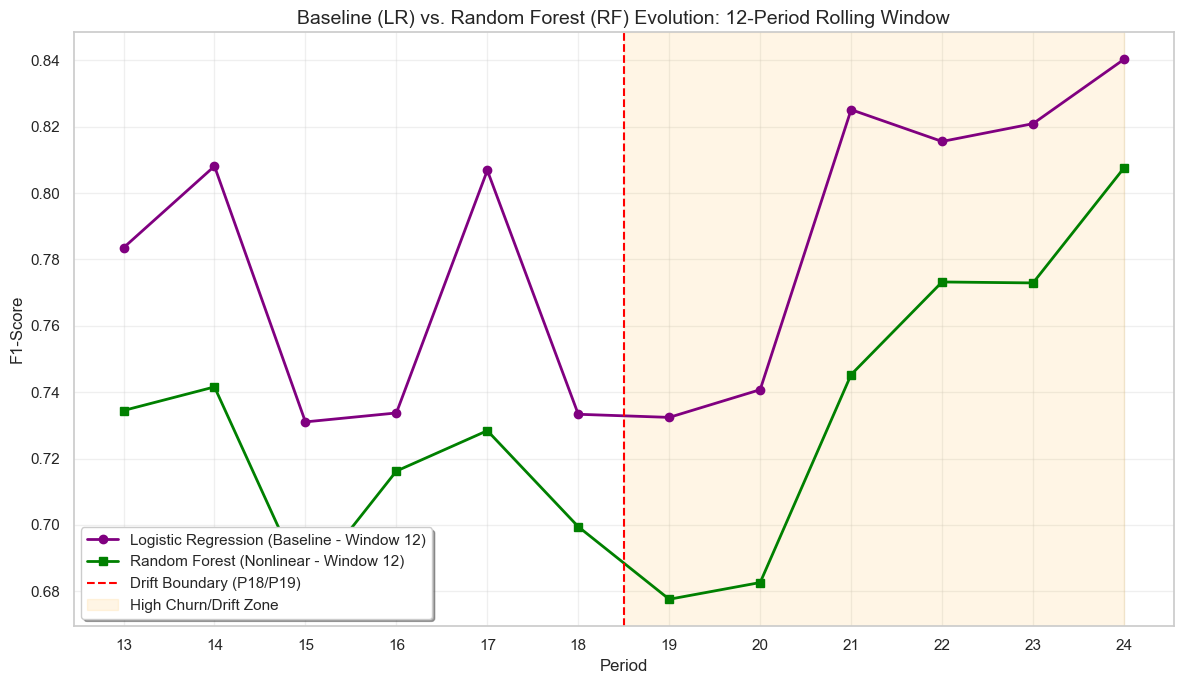

In [52]:
# 4. Generate Performance Comparison Visualization
plt.figure(figsize=(12, 7))
plt.plot(test_periods, f1_lr, label='Logistic Regression (Baseline - Window 12)', color='purple', marker='o', linewidth=2)
plt.plot(test_periods, f1_rf, label='Random Forest (Nonlinear - Window 12)', color='green', marker='s', linewidth=2)

# Highlighting Drift Boundary
plt.axvline(x=18.5, color='red', linestyle='--', label='Drift Boundary (P18/P19)')
plt.axvspan(18.5, 24, alpha=0.1, color='orange', label='High Churn/Drift Zone')

plt.title('Baseline (LR) vs. Random Forest (RF) Evolution: 12-Period Rolling Window', fontsize=14)
plt.xlabel('Period', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(test_periods)
plt.legend(loc='lower left', frameon=True, shadow=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rf_vs_baseline_rolling_comparison.png')

- The most striking observation is that Logistic Regression (Purple) consistently outperforms Random Forest (Green) across almost every period. In many machine learning projects, we expect the complex model (RF) to win. However, in this dataset, the relationship between the features and churn is likely linear.
- The Random Forest appears to be struggling, potentially due to overfitting on the small 12-period training windows or being too sensitive to noise that the Logistic Regression simply ignores.

**Conclusion:** 
LR > RF. The Logistic Regression is more robust, easier to explain to stakeholders, and currently more accurate.

## <a id='step8' style= "font-family: Latin Modern Roman; color: darkblue; ">  Step 8: Business Optimization </a>

**👉 Objective:**

The objective of this final step is to transition from a pure statistical evaluation to a business-driven decision. Standard models usually default to a threshold of $0.5$, but in churn management, the cost of losing a customer is often much higher than the cost of a retention campaign.

### Detailed Business Problem

**The Cost Logic**

In churn prediction, errors are not created equal. We define a Total Economic Loss Function ($L$):$$L(\tau) = (C_{FN} \times FN_{\tau}) + (C_{FP} \times FP_{\tau})$$Where:
- $\tau$: The decision threshold.
- $FN$: A customer churns, and we did nothing (False Negative). 
- $FP$: We offer a discount/promotion to a loyal customer who wasn't going to leave (False Positive).
- $C_{FN}$: The cost of a False Negative. This represents the lost revenue and acquisition costs when a churner is missed.
- $C_{FP}$: The cost of a False Positive. This is the cost of the retention incentive (discount, gift) given to a customer who would have stayed anyway.

**Threshold Optimization**

We iterate through every possible threshold $\tau \in [0, 1]$ to find the value $\tau^*$ that results in the lowest dollar cost for the company. The goal is to find:$$\tau^* = \arg\min_{\tau \in [0,1]} L(\tau)$$

In [56]:
# 1. Define Business Costs
cost_fn = 500  # High cost for missing a churner
cost_fp = 50   # Low cost for a false alarm

# 2. Get probabilities from your Step 7 Random Forest
y_probs = lr.predict_proba(X_test)[:, 1]

# 3. Calculate costs for various thresholds
thresholds = np.linspace(0, 1, 100)
costs = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    fn = ((y_test == 1) & (y_pred_t == 0)).sum()
    fp = ((y_test == 0) & (y_pred_t == 1)).sum()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

In [57]:
# 2. Identify indices for findings
best_idx = np.argmin(costs)
optimal_threshold = thresholds[best_idx]
min_cost = costs[best_idx]
baseline_cost = y_test.sum() * cost_fn # Cost if we do nothing
savings = baseline_cost - min_cost

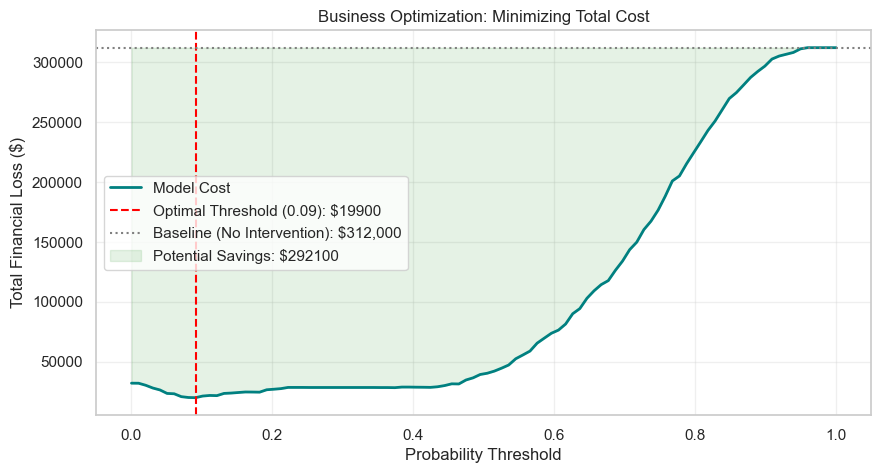

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, costs, color='teal', linewidth=2, label='Model Cost')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f}): ${min_cost}')

# Draw the baseline
plt.axhline(y=baseline_cost, color='gray', linestyle=':', label=f'Baseline (No Intervention): ${baseline_cost:,.0f}')

# Fill the area representing savings
plt.fill_between(thresholds, costs, baseline_cost, color='green', alpha=0.1, label=f'Potential Savings: ${savings}')

plt.title('Business Optimization: Minimizing Total Cost')
plt.xlabel('Probability Threshold')
plt.ylabel('Total Financial Loss ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('cost-optimization.png')
plt.show()

>The curve shows the trade-off between False Negatives (FN) and False Positives (FP):
>- **Left Side (Threshold near 0):**  We are predicting almost everyone will churn. The costs for False Alarm (FP) is high because the company is giving discounts or spending ressources on customers who weren't actually going to leave.
>- **Right Side (Threshold near 1):** We are predicting almost no one will churn. The cost for missing a Churner (FN) explode because the company is losing customers worth  $\$500$ each without any intervention.
>- **The Optimal Threshold(0.09):** indicates that the business is asymmetric, because the cost of missing a churner is 10 times higher than the cost of a false alarm.Therefore, the model should be more aggressive, it's better to waste  $\$50$ on a few extra people (False Positives) to ensure you don't miss those  $\$500$ losses (False Negatives). 

**Business Decision:**
- **The Strategy:** The company should target any customer with a churn probability higher than $37\%$. Direct outreach, phone calls, or high-value personalized offers.
- **The Trade-off:** We will accept many customers who get a discount but weren't leaving because catching the vast majority of actual churners saves the company over $\$292,100$ compared to doing nothing.